# Hand Positioning

The dataset we will analize in this notebook is the Hand Positioning data, containing several .csv files for multiple people who were a part of the research conducted.<br>
<b>The Research:</b>
The research comes to analize behavioural patterns of people. Each person participating in the research was to do three "exercises": Firstly, he/she were to randomly move there hand (and arm) as they wished in any positions. Secondly, two people were put one in front of the other and both were to move there hand and arm as they wished spontaneously. Finally, the two people were to try and synchronize the movement of their hands to match one another (notice that this can be interpreted slightly different by different people). These three tests were recorded for a duration of 75 seconds, by the use of a device called "Leap Motion Controller" (its documentation can be found at the [link](https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html)). This device records (in 60 FPS) multiple characterictics of hands which it detects, for each hand creating a record in the .csv file to be.<br>

The purpose of the notebook and of the research is to perform an analysis of the received data from the device, and given a single frame readings of the data from the "Leap Motion Controller", determine in which of the 3 states ("alone", "spontaneous" or "in sync") the 2 people were. Note that the frames we analize must have 2 hands readings on them. If somehow the device did not detect 2 hands, then the data cannot be used (explained more later in the notebook).<br>
In several instances, the series of tests were conducted twice for a single person. In this case, we shall take only the "most recent" of the tests, when the subject was more comfortable in performing the test. Also, a supplementary dataframe was given to us ("handRight") to fuse with the "alone" dataframes, to help us analize them in the same way as the other two tests.

At the end we recieve multiple .csv files with the data neede. This data has to be processed, united, and then the classifiers must be run to answer the final question of whether it is possible to make such predictions as was asked.

The research paper can be found in the "Data/Hand Positioning" folder of the repository.

In [1]:
#Relevant imports
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import time
from sklearn import metrics
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Loading Data and Preproicessing

The preprocessing of the training and the test sets shall be done simultaneously. Care will be taken not to train or fit data from the training set, only transform it in accordance to what was fitted so that the final classifier we decide on can be then tested on this training set.

First, we shall load the datasets from the local drive.

In [2]:
#Training set
sub1Spont = pd.read_csv('Data/Hand Positioning/Training/Evyatar Cohen/Evyatar636771052727603804Spontan.csv')
sub1Sync = pd.read_csv('Data/Hand Positioning/Training/Evyatar Cohen/Evyatar636771053639929594Sync.csv')
sub1Alone = pd.read_csv('Data/Hand Positioning/Training/Evyatar Cohen/Evyatar636771054555711409Alone.csv')

sub2Spont = pd.read_csv('Data/Hand Positioning/Training/Nofar Social_Nuero/Nofar636759795182793299Spontan.csv')
sub2Sync = pd.read_csv('Data/Hand Positioning/Training/Nofar Social_Nuero/Nofar636759797397919664Sync.csv')
sub2Alone = pd.read_csv('Data/Hand Positioning/Training/Nofar Social_Nuero/Nofar636759796290435160Alone.csv')

sub3Spont = pd.read_csv('Data/Hand Positioning/Training/Oriya Social_Nuero/Oriya636759804404113837Spontan.csv')
sub3Sync = pd.read_csv('Data/Hand Positioning/Training/Oriya Social_Nuero/Oriya636759806131350399Sync.csv')
sub3Alone = pd.read_csv('Data/Hand Positioning/Training/Oriya Social_Nuero/Oriya636759805268396661Alone.csv')

sub4Alone = pd.read_csv('Data/Hand Positioning/Training/Orya Kalmanovitz/OryaB636771082736601528Alone.csv')
sub4Spont = pd.read_csv('Data/Hand Positioning/Training/Orya Kalmanovitz/OryaB636771083605535985Spontan.csv')
sub4Sync = pd.read_csv('Data/Hand Positioning/Training/Orya Kalmanovitz/OryaB636771084494502229Sync.csv')

sub5Alone = pd.read_csv('Data/Hand Positioning/Training/Revital Marbel/Revital636770955999435879Alone.csv')
sub5Spont = pd.read_csv('Data/Hand Positioning/Training/Revital Marbel/Revital636770957038873193Spontan.csv')
sub5Sync = pd.read_csv('Data/Hand Positioning/Training/Revital Marbel/Revital636770957894370062Sync.csv')

sub6Spont = pd.read_csv('Data/Hand Positioning/Training/Shahar Terner/Sachar636771045591258071Spontan.csv')
sub6Sync = pd.read_csv('Data/Hand Positioning/Training/Shahar Terner/Sachar636771046527112972Sync.csv')
sub6Alone = pd.read_csv('Data/Hand Positioning/Training/Shahar Terner/Sachar636771047408504303Alone.csv')

sub7Spont = pd.read_csv('Data/Hand Positioning/Training/Shelly Social_Nuero/Shelly636759787508979097Spontan.csv')
sub7Sync = pd.read_csv('Data/Hand Positioning/Training/Shelly Social_Nuero/Shelly636759789526313406Sync.csv')
sub7Alone = pd.read_csv('Data/Hand Positioning/Training/Shelly Social_Nuero/Shelly636759788383205274Alone.csv')

sub8Spont = pd.read_csv('Data/Hand Positioning/Training/Yael Hagai/Yael636771059544754823Spontan.csv')
sub8Sync = pd.read_csv('Data/Hand Positioning/Training/Yael Hagai/Yael636771060699529085Sync.csv')
sub8Alone = pd.read_csv('Data/Hand Positioning/Training/Yael Hagai/Yael636771061659067649Alone.csv')

sub9Spont = pd.read_csv('Data/Hand Positioning/Training/Yoel Raz/Yoel636760921663075813Spontan.csv')
sub9Sync = pd.read_csv('Data/Hand Positioning/Training/Yoel Raz/Yoel636760923490742912Sync.csv')
sub9Alone = pd.read_csv('Data/Hand Positioning/Training/Yoel Raz/Yoel636760922573364655Alone.csv')
#27 dataframes

handRight = pd.read_csv('Data/Hand Positioning/HandRight.csv')

#Final Test Set
sub1TestSpont = pd.read_csv('Data/Hand Positioning/Validation/Itiel Lab/Itiel636770940701219076Spontan.csv')
sub1TestSync = pd.read_csv('Data/Hand Positioning/Validation/Itiel Lab/Itiel636770941638547912Sync.csv')
sub1TestAlone = pd.read_csv('Data/Hand Positioning/Validation/Itiel Lab/Itiel636770942529041679Alone.csv')

sub2TestSpont = pd.read_csv('Data/Hand Positioning/Validation/Mor SHerman/Mor636771064635567065Spontan.csv')
sub2TestSync = pd.read_csv('Data/Hand Positioning/Validation/Mor SHerman/Mor636771065531910215Sync.csv')
sub2TestAlone = pd.read_csv('Data/Hand Positioning/Validation/Mor SHerman/Mor636771066407626524Alone.csv')

sub3TestSpont = pd.read_csv('Data/Hand Positioning/Validation/Oded Medina/Oded636754670490266956Spontan.csv')
sub3TestSync = pd.read_csv('Data/Hand Positioning/Validation/Oded Medina/Oded636754671560850581Sync.csv')
sub3TestAlone = pd.read_csv('Data/Hand Positioning/Validation/Oded Medina/Oded636754669540564461Alone.csv')

Next, we unite each type of test (alone, spontaneous and sync) into separate lists, as the processing of the different types is slightly different. This is done, too, on the final test set. The lengths of the total lists is printed to make sure they are of the correct size.

In [3]:
aloneList = [sub1Alone, sub2Alone, sub3Alone, sub4Alone, sub5Alone, sub6Alone, sub7Alone, sub8Alone, sub9Alone]
syncList = [sub1Sync, sub2Sync, sub3Sync, sub4Sync, sub5Sync, sub6Sync, sub7Sync, sub8Sync, sub9Sync]
spontList = [sub1Spont, sub2Spont, sub3Spont, sub4Spont, sub5Spont, sub6Spont, sub7Spont, sub8Spont, sub9Spont]
totalList = aloneList + syncList + spontList
print (len(totalList))

aloneListTest = [sub1TestAlone, sub2TestAlone, sub3TestAlone]
syncListTest = [sub1TestSync, sub2TestSync, sub3TestSync]
spontListTest = [sub1TestSpont, sub2TestSpont, sub3TestSpont]
totalListTest = aloneListTest + syncListTest + spontListTest
print(len(totalListTest))

27
9


### Preprocessing

To make sure our future classfifiers work correctly, we must make sure there are no NaN values in the dataframes given to us. We can see that there are no such values.

In [4]:
count = 0
for i in range(len(totalList)):
    count += totalList[i].isna().sum().sum()
    
countTest = 0
for i in range(len(totalListTest)):
    countTest += totalListTest[i].isna().sum().sum()
    
count + countTest

0

The column names in the dataframes have spaces in them. This prevents or makes it much more complicated for us to run many functions, so we wish to remove the spaces from the column names. This is done for all data at our disposal, then all sublists are united again into a totalList (this is done several times throughout the notebook)

In [5]:
def removeSpaces(someList):
    for i in range(len(someList)):
        someList[i].columns = someList[i].columns.str.replace(' ', '')
    return someList


aloneList = removeSpaces(aloneList)
syncList = removeSpaces(syncList)
spontList = removeSpaces(spontList)
totalList = aloneList + syncList + spontList
    
handRight.columns = handRight.columns.str.replace(' ', '')

aloneListTest = removeSpaces(aloneListTest)
syncListTest = removeSpaces(syncListTest)
spontListTest = removeSpaces(spontListTest)
totalListTest = aloneListTest + syncListTest + spontListTest

def removeSpaces(someList)
for i in range(len(someList)):
    someList[i].columns = someList[i].columns.str.replace(' ', '')
for i in range(len(syncList)):
    syncList[i].columns = syncList[i].columns.str.replace(' ', '')
for i in range(len(spontList)):
    spontList[i].columns = spontList[i].columns.str.replace(' ', '')
totalList = aloneList + syncList + spontList
    
handRight.columns = handRight.columns.str.replace(' ', '')



As was mentioned at the start of the notebook, the number of hands detected by the device is not always the correct one. For example some records in the "sync" section have 1 hand detected, whereas at all times there were 2 people sitting one in front of the other, participating in the experiment. Likewise, in the "alone" section some records detected 2 hands, although only 1 person participated in the recording of the experiment. We want to remove the records where the number of hands detected was incorrect. We first show the unique values in the "#hands" column, to know if we need to notice them differently. This is not the case, as every dataframe has either one unique value (the correct one), or two unique values where one of them is incorrect and has to be removed. We will, anyway, for simplicity's sake, go over all dataframes (even those with only the correct value).<br>
Also, if such records exist in the "alone" dataframes where the hand recorded was the right hand, this, too, is not right, so we remove these records.

In [6]:
#viewing unique values of every dataframe in the "#hands" column
for i in range(len(totalList)):
    print(totalList[i]['#hands'].unique())

[1]
[1 2]
[1]
[1]
[1 2]
[1]
[1]
[1 2]
[1]
[2]
[2]
[2 1]
[2]
[2 1]
[2 1]
[2]
[2 1]
[2]
[2]
[2 1]
[2 1]
[2 1]
[2 1]
[2]
[2]
[2 1]
[2 1]


In [9]:
#removing records with incorrect number of hands
for i in range(len(aloneList)):
    temp = aloneList[i]
    temp = temp[temp['#hands'] == 1]
    aloneList[i] = temp[temp['HandType'] == 'left']
        

for i in range(len(spontList)):
    temp = spontList[i]
    spontList[i] = temp[temp['#hands'] == 2]
    

for i in range(len(syncList)):
    temp = syncList[i]
    syncList[i] = temp[temp['#hands'] == 2]

totalList = aloneList + spontList + syncList

handRight = handRight[handRight['#hands'] == 1]

for i in range(len(aloneListTest)):
    temp = aloneListTest[i]
    temp = temp[temp['#hands'] == 1]
    aloneListTest[i] = temp[temp['HandType'] == 'left']
        

for i in range(len(spontListTest)):
    temp = spontListTest[i]
    spontListTest[i] = temp[temp['#hands'] == 2]
    

for i in range(len(syncListTest)):
    temp = syncListTest[i]
    syncListTest[i] = temp[temp['#hands'] == 2]
    
totalListTest = aloneListTest + syncListTest + spontListTest

Below, we again list the unique values of each dataframe in the "#hands" column, to make sure that the fumction and the code above work as expected.

In [10]:
#checking that the code worked
for i in range(len(totalList)):
    temp = totalList[i]['#hands'].unique()
    print(temp)

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


Below, we perform the actions performed on the lists of dataframes above, on the dataframe of handRight, to prepare it for future merging with the lists. The actions performed are: removing records where the recorded hand was categorized as the left hand, where there are NaN values in the dataframe (there are only 34 such values, so it makes little difference whether we remove them or not, so we will not even try to find replacement values for the NaN). We also have to reset the index of the dataframe, as some records were removed, and we wish to keep the indexes continuous, with no gaps.

In [10]:
#Removing all records where the hand recorded was the left hand
handRight = handRight[handRight['HandType'] == 'right']

#Removing all records where there are NaN values (were 34 such)
handRight = handRight.drop(handRight[handRight.isna().any(axis=1)].index)

handRight = handRight.reset_index() #resetting index of the handRight for future merging
handRight = handRight.drop(['index'], axis = 1)

We can notice that the "Time" column of each dataframe does not start with 0, most likely due to the algorithms inside the device used for recording. We want to correct this mistake and subtract the first value in the column from all records, so the first record's time will be 0.0, and the last records time will be very close to 75.

In [11]:
#resetting time in all dfs to start from 0
warnings.filterwarnings('ignore')
for i in range(len(aloneList)):
    aloneList[i]['Time'] = aloneList[i]['Time'] - aloneList[i].loc[0]['Time']
for i in range(len(spontList)):
    spontList[i]['Time'] = spontList[i]['Time'] - spontList[i].loc[0]['Time']
for i in range(len(syncList)):
    syncList[i]['Time'] = syncList[i]['Time'] - syncList[i].loc[0]['Time']

totalList = aloneList + spontList + syncList
handRight['Time'] = handRight['Time'] - handRight.loc[0]['Time']


for i in range(len(aloneListTest)):
    aloneListTest[i]['Time'] = aloneListTest[i]['Time'] - aloneListTest[i].loc[0]['Time']
for i in range(len(spontListTest)):
    spontListTest[i]['Time'] = spontListTest[i]['Time'] - spontListTest[i].loc[0]['Time']
for i in range(len(syncListTest)):
    syncListTest[i]['Time'] = syncListTest[i]['Time'] - syncListTest[i].loc[0]['Time']

totalListTest = aloneListTest + syncListTest + spontListTest

As specified in the instructions, and due to subjects not being very comfortable in what they are doing, we decide to remove the first 7 seconds of every dataframe from consideration.

In [12]:
#Removing first 7 seconds from each df
for i in range(len(aloneList)):
    aloneList[i] = aloneList[i].loc[aloneList[i]['Time'] > 7]
for i in range(len(spontList)):
    spontList[i] = spontList[i].loc[spontList[i]['Time'] > 7]
for i in range(len(syncList)):
    syncList[i] = syncList[i].loc[syncList[i]['Time'] > 7]

handRight = handRight.loc[handRight['Time'] > 7]
totalList = aloneList + spontList + syncList

for i in range(len(aloneListTest)):
    aloneListTest[i] = aloneListTest[i].loc[aloneListTest[i]['Time'] > 7]
for i in range(len(spontListTest)):
    spontListTest[i] = spontListTest[i].loc[spontListTest[i]['Time'] > 7]
for i in range(len(syncListTest)):
    syncListTest[i] = syncListTest[i].loc[syncListTest[i]['Time'] > 7]

totalListTest = aloneListTest + syncListTest + spontListTest

Now that our dataframes are ready, we can merge the "alone" dataframes with that of "handRight". We need to merge them alternatingly (first row from 1 dataframe, then first row from handRight, then second from the dataframe, and so on). Note that "handRight" is not of the same length as the dataframes in "aloneList", so we have to expand it by duplicating it as many times as needed so the number of records match. To correct any "wholes" in indexes of the dataframes, we reset the index of each of them before the merging, and also after the merge. The aloneList is updated to the merged dataframes.

In [13]:
#Combining alone with RightHand
handRightBigger = handRight
for i in range(len(aloneList)):
    aloneList[i] = aloneList[i].reset_index() #resetting index of the aloneList value for merging
    aloneList[i] = aloneList[i].drop(['index'], axis = 1)
    
    handRightBigger = handRight
    while (len(handRightBigger) < len(aloneList[i])): #Expanding the handRight datframe as many times as needed
        handRightBigger = pd.concat([handRightBigger, handRight], ignore_index = True)
    numToDrop = len(handRightBigger) - len(aloneList[i]) #Number of rows to drop from the end of the data to match
    #the length of "df"
    handRightBigger.drop(handRightBigger.tail(numToDrop).index, inplace = True)
    handRightBigger = handRightBigger.reset_index() #resetting index of the handRightBigger for merging
    handRightBigger = handRightBigger.drop(['index'], axis = 1)
    
    aloneList[i] = pd.concat([handRightBigger, aloneList[i]]).sort_index(kind='merge') #merging
    aloneList[i] = aloneList[i].reset_index() #resetting index of the aloneList[i]
    aloneList[i] = aloneList[i].drop(['index'], axis = 1)
    
totalList = aloneList + spontList + syncList

for i in range(len(aloneListTest)): #Doing the same for final test data.
    aloneListTest[i] = aloneListTest[i].reset_index() #resetting index of the aloneListTest value for merging
    aloneListTest[i] = aloneListTest[i].drop(['index'], axis = 1)
    
    handRightBigger = handRight
    while (len(handRightBigger) < len(aloneListTest[i])): #Expanding the handRight datframe as many times as needed
        handRightBigger = pd.concat([handRightBigger, handRight], ignore_index = True)
    numToDrop = len(handRightBigger) - len(aloneListTest[i]) #Number of rows to drop from the end of the data
    #to match the length of "df"
    handRightBigger.drop(handRightBigger.tail(numToDrop).index, inplace = True)
    handRightBigger = handRightBigger.reset_index() #resetting index of the handRightBigger for merging
    handRightBigger = handRightBigger.drop(['index'], axis = 1)
    
    aloneListTest[i] = pd.concat([handRightBigger, aloneListTest[i]]).sort_index(kind='merge') #merging
    aloneListTest[i] = aloneListTest[i].reset_index() #resetting index of the aloneListTest[i]
    aloneListTest[i] = aloneListTest[i].drop(['index'], axis = 1)

Our data is almost ready for combination (two actions remain). First of these is the addition of labels to the data. We classify "alone" lists as 0, "spont" as 1 and "sync" as 2 (We are going to have a multiclass problem on our hands).

In [14]:
#Adding labels to data
for i in range(len(aloneList)):
    aloneList[i]['label'] = 0
for i in range(len(spontList)):
    spontList[i]['label'] = 1
for i in range(len(syncList)):
    syncList[i]['label'] = 2
    
totalList = aloneList + spontList + syncList

for i in range(len(aloneListTest)):
    aloneListTest[i]['label'] = 0
for i in range(len(spontListTest)):
    spontListTest[i]['label'] = 1
for i in range(len(syncListTest)):
    syncListTest[i]['label'] = 2
    
totalListTest = aloneListTest + syncListTest + spontListTest

Finally, we need to somehow merge every two consecutive rows into one, as we need our classifiers to compare each left and right hand together, not as two unrelated records. Note that not each time the right hand comes before left hand, or vice versa, so we need to check for each two rows which one is "HandType" == 'right' and which one is left. We decide to do the merge by "moving" the left hand for each of the 2 consecutive rows to the end of the record, essentially doubling the number of features in each dataframe and halving the number of records. To do so, we need to first create a new dataframe with the appropriate names for features (appending "Right" and "Left" respectively to every column's name.<br>
Again, each dataframe uses reset_index to fill any wholes in indexes before the merge (no need to do so after the merge as in the next cell the datasets are merged into one).

In [15]:
#function to combine 2 consecutive rows
start_timeCombine = time.time()

liR = ["{}{}".format(ind,'Right') for ind in totalList[0].columns] #appending "right" to the end of each column name
liL = ["{}{}".format(ind,'Left') for ind in totalList[0].columns]
LiTotal = liR + liL

for j in range(len(totalList)): #Iterating over every dataframe in the list
    flattenedDf = pd.DataFrame(columns = LiTotal) #empty df
    totalList[j] = totalList[j].reset_index() #resetting index of the totalList[j] for merging
    totalList[j] = totalList[j].drop(['index'], axis = 1)
    
    for i in range(0, len(totalList[j]), 2): #Iterating over every record in the dataframe with jumps of 2 (due to
        #every iteration using 2 consecutive rows for merging)
        if (totalList[j].loc[i]['HandType'] == 'right'):
            right = i
            left = i+1
        else:
            left = i
            right = i+1
    
        rightList = totalList[j].loc[right]
        rightList.index = liR
        
        leftList = totalList[j].loc[left]
        leftList.index = liL
    
        completeRecord = pd.concat([rightList, leftList])
        flattenedDf = flattenedDf.append(completeRecord, ignore_index = True)
    totalList[j] = flattenedDf
    


    
#Doing the same for test data.
for j in range(len(totalListTest)): #Iterating over every dataframe in the list
    flattenedDf = pd.DataFrame(columns = LiTotal) #empty df
    totalListTest[j] = totalListTest[j].reset_index() #resetting index of the totalListTest[j] for merging
    totalListTest[j] = totalListTest[j].drop(['index'], axis = 1)
    
    for i in range(0, len(totalListTest[j]), 2): #Iterating over every record in the dataframe with jumps of 2 (due to
        #every iteration using 2 consecutive rows for merging)
        if (totalListTest[j].loc[i]['HandType'] == 'right'):
            right = i
            left = i+1
        else:
            left = i
            right = i+1
    
        rightList = totalListTest[j].loc[right]
        rightList.index = liR
        
        leftList = totalListTest[j].loc[left]
        leftList.index = liL
    
        completeRecord = pd.concat([rightList, leftList])
        flattenedDf = flattenedDf.append(completeRecord, ignore_index = True)
    totalListTest[j] = flattenedDf
    
    

timeCombine = time.time() - start_timeCombine
print("Time taken to achive result: %s seconds" % (timeCombine))

Time taken to achive result: 797.0763785839081 seconds


Now we can finally merge all the dataframes into one (and another one for the test data). This is done in the code below by initializing an emty dataframe and using .concat() to append every consecutive dataframe into one.

In [16]:
#Merging all dfs into 1
fulldf = totalList[0]
for i in range(1, len(totalList)):
    fulldf = pd.concat([fulldf, totalList[i]], ignore_index = True)

#Merging all test dfs into 1
fulldfTest = totalListTest[0]
for i in range(1, len(totalListTest)):
    fulldfTest = pd.concat([fulldfTest, totalListTest[i]], ignore_index = True)
    
    
fulldf

,TimeRight,FrameIDRight,HandTypeRight,#handsRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,...,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft,labelLeft
0,7.0141,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.34660,-57.68153,...,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0,0
1,7.0311,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.83740,-77.18515,...,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0,0
2,7.0474,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.00330,-43.79815,...,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0,0
3,7.0641,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.21200,-43.99948,...,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0,0
4,7.0807,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.45130,-53.88054,...,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102665,74.8080,67304,right,2,97.75611,205.9629,30.046510,28.362980,77.44335,162.14280,...,-107.85000,127.8215,32.852500,-318.7630,20.751860,138.012500,0.0,0.000000,0.0,2
102666,74.8406,67306,right,2,98.93275,208.3153,34.859910,44.383930,71.36857,187.54080,...,-108.08050,128.1729,33.403910,-314.6744,14.308990,139.990900,0.0,0.000000,0.0,2
102667,74.8746,67309,right,2,101.91230,212.0264,42.535680,79.958100,113.41030,190.77140,...,-109.00180,129.5246,33.898560,-304.9600,-0.548136,142.010900,0.0,0.000000,0.0,2
102668,74.9073,67311,right,2,103.84750,214.7484,47.070820,61.117730,95.13531,155.74530,...,-109.72500,130.7078,34.033600,-295.5957,-14.978170,140.026300,0.0,0.000000,0.0,2


To quicken the runtime on future runs, we export the dataframe recieved to the local disk, then load it again to make sure that the exportation worked properly (The notebook can be run from here in the future).

In [17]:
fulldf.to_csv('Data/Hand Positioning/df.csv')

In [204]:
fulldf = pd.read_csv('Data/Hand Positioning/df.csv')
fulldf = fulldf.drop(['Unnamed: 0'], axis = 1)
fulldf

,TimeRight,FrameIDRight,HandTypeRight,#handsRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,...,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft,labelLeft
0,7.0141,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.34660,-57.68153,...,-101.04550,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.0,0.073635,0.0,0
1,7.0311,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.83740,-77.18515,...,-95.51471,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.0,0.018766,0.0,0
2,7.0474,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.00330,-43.79815,...,-94.32024,128.7403,2.742160,-322.1467,20.402740,-2.617105,0.0,0.018409,0.0,0
3,7.0641,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.21200,-43.99948,...,-99.72611,127.6519,5.047988,-331.5826,28.883190,-7.521224,0.0,0.149852,0.0,0
4,7.0807,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.45130,-53.88054,...,-102.66840,128.2257,6.734126,-333.9562,27.848030,-3.312394,0.0,0.242324,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102665,74.8080,67304,right,2,97.75611,205.9629,30.046510,28.362980,77.44335,162.14280,...,-107.85000,127.8215,32.852500,-318.7630,20.751860,138.012500,0.0,0.000000,0.0,2
102666,74.8406,67306,right,2,98.93275,208.3153,34.859910,44.383930,71.36857,187.54080,...,-108.08050,128.1729,33.403910,-314.6744,14.308990,139.990900,0.0,0.000000,0.0,2
102667,74.8746,67309,right,2,101.91230,212.0264,42.535680,79.958100,113.41030,190.77140,...,-109.00180,129.5246,33.898560,-304.9600,-0.548136,142.010900,0.0,0.000000,0.0,2
102668,74.9073,67311,right,2,103.84750,214.7484,47.070820,61.117730,95.13531,155.74530,...,-109.72500,130.7078,34.033600,-295.5957,-14.978170,140.026300,0.0,0.000000,0.0,2


We can next double check that every two labels in the dataframe recieved (one label of the right hand and one of the left). We expect and recieve an emty dataframe, meaning all labels are the same and the merge of 2 consecutive columns worked properly (more tests were run to verify this, but are not shown for the sake of compactness of the notebook).

In [205]:
#Check that all labels in labelLeft and labelRight are the same, hence one can be removed
fulldf[fulldf['labelLeft'] != fulldf['labelRight']]

,TimeRight,FrameIDRight,HandTypeRight,#handsRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,...,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft,labelLeft


To quicken runtime and reduce noise of future classifiers, we need to remove further unneeded features:
- #hands: no longer needed as it was used already to siphon incorrect data, when the wrong number of hands was identified by the device. Also, this feature would give a significant boost to the classifier to determine if the record is of "alone" or not, as all the alone class has this value of 1, and both other classes have the value 2. This is true for both columns that count the number of hands.
- Time: The time feature is of little to no use for the classsifier as it records the amount of time that has passed from the start of the experiment. We have used it to delete first seven seconds of each dataframe, but is not needed further.
- FrameID: A unique identifier of each frame is, too, unneeded, as does not provide relevant information for the classifiers.
- HandType: Was used to combine every 2 consecutive rows, now all records in the feature contain the exact same value ("HandTypeRight" == "right", "HandTypeLeft" == "left").

Furthermore, as we delete the label of the right hand, we remain with one label in a row (as we are supposed to). Hence we can rename the row for further clarity.

In [206]:
fulldf = fulldf.drop(['#handsRight', '#handsLeft', 'TimeRight', 'TimeLeft', 'FrameIDRight', 'FrameIDLeft',
                        'HandTypeRight', 'HandTypeLeft', 'labelRight'], axis = 1) #Further unneeded attributes
fulldf = fulldf.rename(columns={'labelLeft': 'label'})

fulldfTest = fulldfTest.drop(['#handsRight', '#handsLeft', 'TimeRight', 'TimeLeft', 'FrameIDRight', 'FrameIDLeft',
                        'HandTypeRight', 'HandTypeLeft', 'labelRight'], axis = 1) #Further unneeded attributes
fulldfTest = fulldfTest.rename(columns={'labelLeft': 'label'})

fulldf

We can notice that in between 2 frames, not much changes in terms of the characteristics measured. Because of this, and in order to improve the runtime of future models, we can take every nth row instead of every single row. In our case, I believe that taking every 5th record is the best correlation between runtime reduction and accuracy reduction (after several tests, some of which are described later). We do not do this for the test set, as we do not run .fit() on the testing set.

In [164]:
#every 5th row
fulldf = fulldf.iloc[::5, :]

fulldf = fulldf.reset_index() #resetting index of the handRight for merging
fulldf = fulldf.drop(['index'], axis = 1)

Below we create a dataframe of correlations between every attribute with one another. The dataframe represents the linear correlation between the attributes (nonlinear relations have very low values as the functions considers only linear relations). The values range between -1 and 1, where positive values represent positive relations ("as X increases, Y increases"), while negative value represent negative relations ("as X increases, Y decreases"). Each attribute has an exact linear relation with itself (1.0000). A final thing to note is that the table presented has many duplicates (we could remove the upper right triangle (if the table were cut diagonally from the upper-left corner to the lower-right corner), and not lose any data).<br>
Using this data, we plot a heatmap using seaborn, to better and easier see the higher values.

<AxesSubplot:>

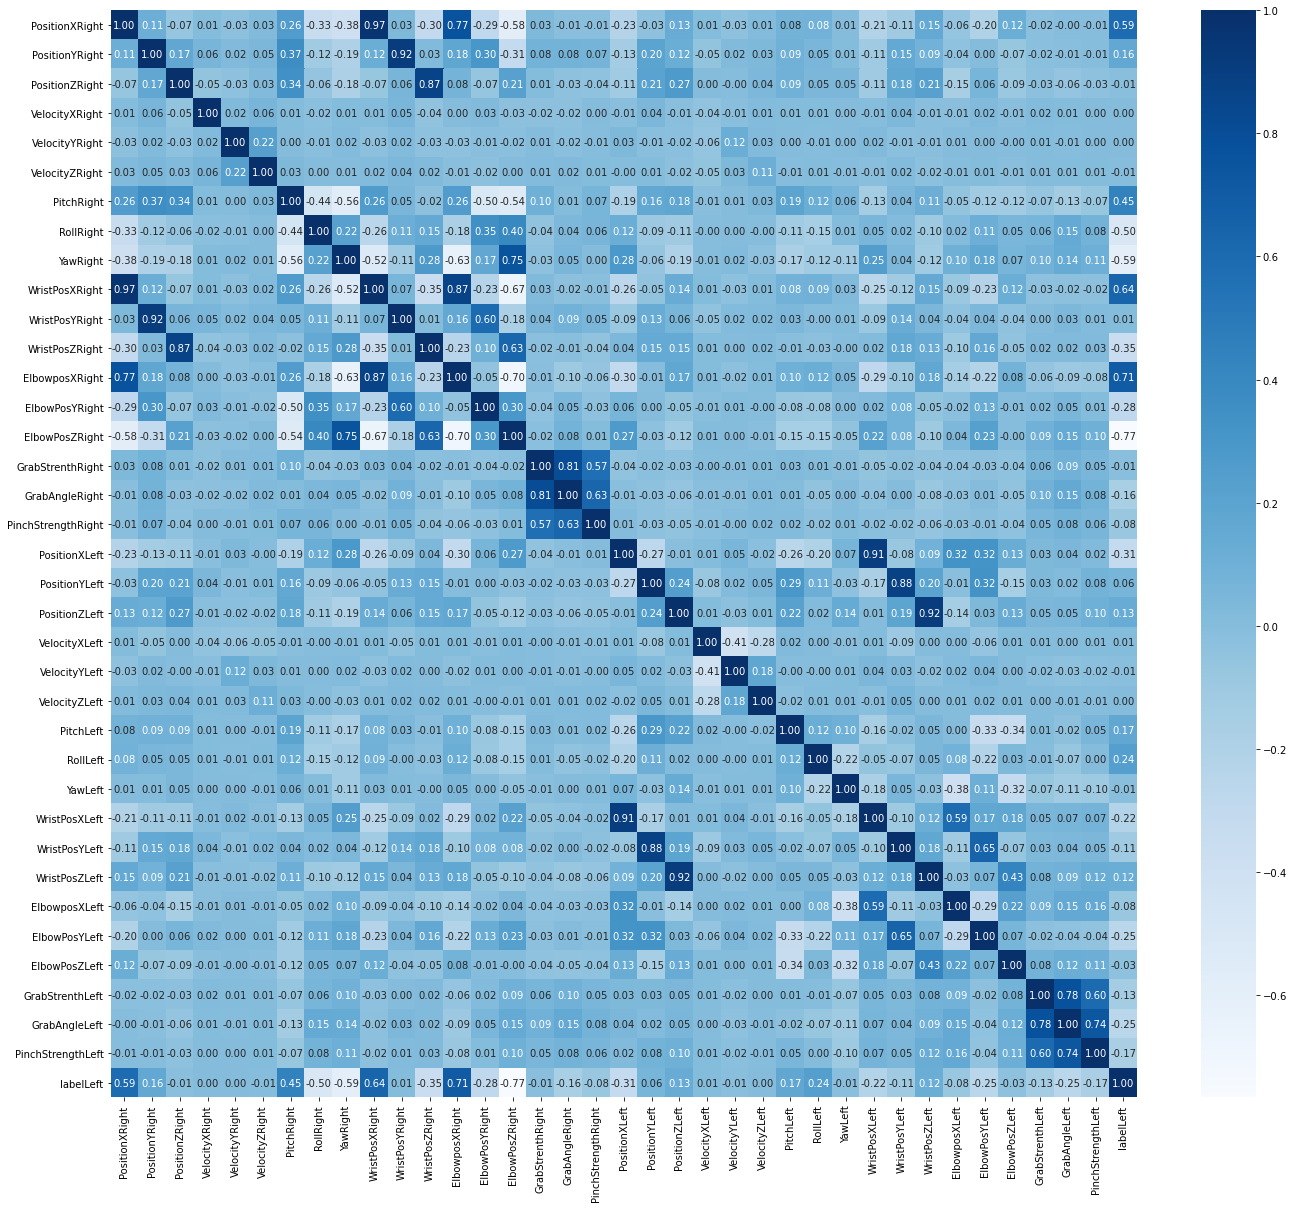

In [178]:
plt.figure(figsize=(23,20))
sns.heatmap(fulldf.corr(), cmap = 'Blues', annot=True, fmt=".2f")

We can see that 4 pairs of features have a correlation of more than 0.9, meaning there is an extremely high linear correlation between the features. Corretlations of less than 0.9 were not taken into account after some tests due to them reducing accuracy by more than 0.5%, while not improving runtime. Regarding the four pairs with very high correlation:
- PositionXRight vs WristPosXRight
- PositionYRight vs WristPosYRight
- PositionXLeft vs WristPosXLeft
- PositionZLeft vs WristPosZLeft

Due to their very high correlation, we can unite these features into one and remove the remaining. We could simly remove one of the features, and the accuracy of the classifiers will not drop significantly, but I believe it best to keep spme relation between the pairs. We decide to multiply the values of each pair, thus maintaining some relation between the pairs, and correcting some of the mistakes made by removing one of the features.

In [208]:
#Training set
fulldf['PositionXRight'] = fulldf['PositionXRight'] * fulldf['WristPosXRight']
fulldf['PositionYRight'] = fulldf['PositionYRight'] * fulldf['WristPosYRight']

fulldf['PositionXLeft'] = fulldf['PositionXLeft'] * fulldf['WristPosXLeft']
fulldf['PositionZLeft'] = fulldf['PositionZLeft'] * fulldf['WristPosZLeft']

fulldf = fulldf.drop(['WristPosXRight', 'WristPosYRight', 'WristPosXLeft',
                      'WristPosZLeft'], axis = 1) #Further unneeded attributes

#Test set
fulldfTest['PositionXRight'] = fulldfTest['PositionXRight'] * fulldfTest['WristPosXRight']
fulldfTest['PositionYRight'] = fulldfTest['PositionYRight'] * fulldfTest['WristPosYRight']

fulldfTest['PositionXLeft'] = fulldfTest['PositionXLeft'] * fulldfTest['WristPosXLeft']
fulldfTest['PositionZLeft'] = fulldfTest['PositionZLeft'] * fulldfTest['WristPosZLeft']

fulldfTest = fulldfTest.drop(['WristPosXRight', 'WristPosYRight', 'WristPosXLeft',
                              'WristPosZLeft'], axis = 1) #Further unneeded attributes

Below are the histograms of every attribute and the with the attribute values as the x axis and the number of records with said value in said attribute as the y axis. For our purposes, it is of almost no significance, except to visually understand the approximate distributions of values over the dataframe. This is needed in turn to understand that the data is not "capped" on either end (for example), meaning that the actual values were not rounded to a certain value if they were above that value, and likewise below. Another use for the histograms is seeing that there are sufficient records for most if not all values of every attribute, for example if all of the feature "GrabStrengthRight" or "PinchStrengthRight" were 0 (almost all are 0), there will be no point of that attribute for the model's purposes and could be removed (maybe it is still the case, but is not as straightforward).

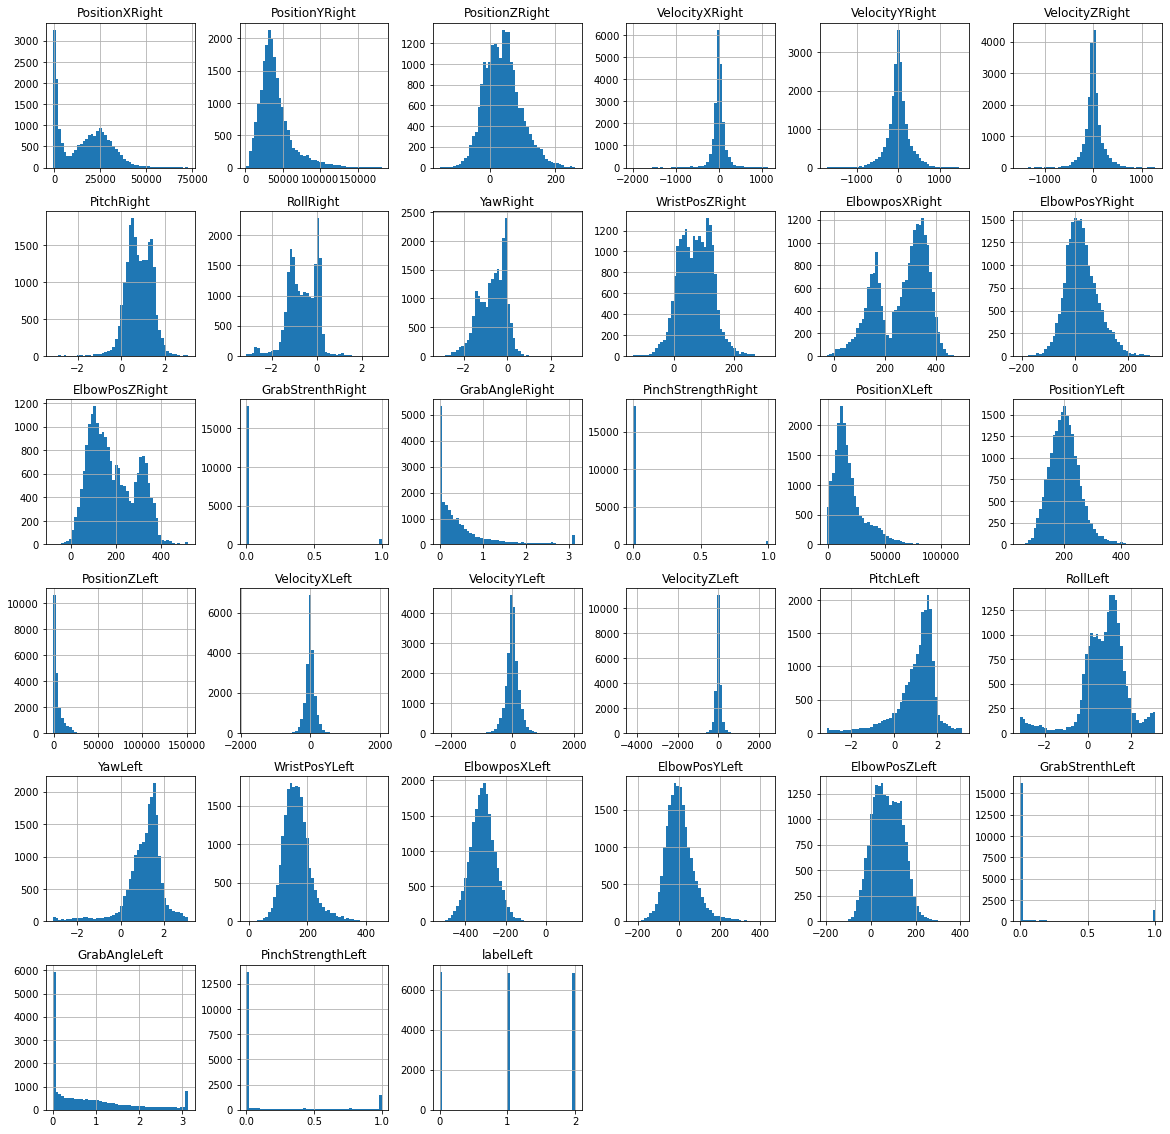

In [169]:
fulldf.hist(bins=50, figsize=(20,20))
plt.show()

As we could see in the histogram above, but an accent should be put on this, the amount of data (records) for each label is almost the same, meaning that we are dealing with balanced data.

In [210]:
print('labels:\n', fulldf['label'].value_counts(), '\n')

labels:
 0    34444
1    34182
2    34044
Name: label, dtype: int64 



In preparation for the train_test_split and for the classifiers, we must separate the labels from the training data.

In [211]:
x = fulldf.drop(['label'], axis = 1)
y = fulldf['label']

As we do not want to introduce bias when constructing and tuning our classifiers, we wish to not touch the testing set right up to the end, after the best classifier was chosen, we shall split the training set itself into a training and testing set (can also be called validation set), on which we shall run and tune our classifiers. We choose the size of both testing sets to be 10% of the data from which it splits, as the 10% are, in my opinion, enough to determine the quality of the classifiers.

In [212]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [213]:
def scale(X_train, X_test):
    min_max_scaler = MinMaxScaler()
    X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train.values)) #fitting and transforming on train data
    X_test = pd.DataFrame(min_max_scaler.transform(X_test.values)) #only transforming the test and validation sets
    return X_train, X_test

X_train, X_test = scale(X_train, X_test)

In [196]:
def PCAFunc(X_train, X_test):
    pca = PCA(n_components=0.99)
    X_train_Reduced = pd.DataFrame(pca.fit_transform(X_train))
    X_test_Reduced = pd.DataFrame(pca.transform(X_test))
    return X_train_Reduced, X_test_Reduced

X_train, X_test = PCAFunc(X_train, X_test)

In [214]:
X_train.shape

(92403, 32)

Accuracy (XGBoost):  0.9997078016947502
Time taken to achive result: 315.52544021606445 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3520
           1       1.00      1.00      1.00      3344
           2       1.00      1.00      1.00      3403

    accuracy                           1.00     10267
   macro avg       1.00      1.00      1.00     10267
weighted avg       1.00      1.00      1.00     10267



<AxesSubplot:>

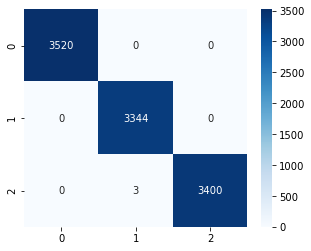

In [215]:
#XGBoost
start_timeXGBoost = time.time()
modelXGBoost = XGBClassifier(learning_rate = 0.1,
                             n_estimators = 4000,
                             verbosity = 0,
                             use_label_encoder = False,
                             n_jobs = -1)
modelXGBoost.fit(X_train, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test)
accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achive result: %s seconds" % (timeXGBoost))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsXGBoost))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')
# 0.9973707274320771   77.91330695152283 seconds

#Accuracy (XGBoost):  0.9814995131450828

In [157]:
list(x.columns)

['PositionXRight',
 'PositionYRight',
 'PositionZRight',
 'VelocityXRight',
 'VelocityYRight',
 'VelocityZRight',
 'PitchRight',
 'RollRight',
 'YawRight',
 'WristPosZRight',
 'ElbowposXRight',
 'ElbowPosYRight',
 'ElbowPosZRight',
 'GrabStrenthRight',
 'GrabAngleRight',
 'PinchStrengthRight',
 'PositionXLeft',
 'PositionYLeft',
 'PositionZLeft',
 'VelocityXLeft',
 'VelocityYLeft',
 'VelocityZLeft',
 'PitchLeft',
 'RollLeft',
 'YawLeft',
 'WristPosYLeft',
 'ElbowposXLeft',
 'ElbowPosYLeft',
 'ElbowPosZLeft',
 'GrabStrenthLeft',
 'GrabAngleLeft',
 'PinchStrengthLeft']

In [50]:
totalList[20].loc[8160:8200]

,Time,FrameID,HandType,#hands,PositionX,PositionY,PositionZ,VelocityX,VelocityY,VelocityZ,...,Yaw,WristPosX,WristPosY,WristPosZ,ElbowposX,ElbowPosY,ElbowPosZ,GrabStrenth,GrabAngle,PinchStrength
8160,594.0887,68547,left,2,-234.2994,258.0880,38.83411,-211.845700,235.69670,89.94535,...,1.467242,-283.8514,204.6550,34.02165,-467.2405,23.338590,14.421280,0.0,0.725797,0.000000
8161,594.1050,68549,right,2,179.2210,156.4745,105.40620,-371.133200,-348.04380,-192.14450,...,-1.053611,238.2967,181.0261,133.89760,396.2469,39.482950,281.913300,0.0,0.529831,0.000000
8162,594.1050,68549,left,2,-238.4600,263.3977,40.27891,-214.514500,298.55190,104.69660,...,1.488094,-283.1490,206.0837,34.37842,-478.6859,37.310150,21.254710,0.0,0.758618,0.000000
8163,594.1216,68551,right,2,172.2930,150.1108,100.17530,-388.670000,-358.54790,-361.86120,...,-1.046189,231.0670,175.2778,128.98130,390.4013,39.744900,281.082700,0.0,0.513158,0.000000
8164,594.1216,68551,left,2,-240.9339,267.9396,41.88597,-71.738730,196.88630,66.51275,...,1.559084,-281.5696,208.0451,33.85419,-469.8535,30.741810,31.820660,0.0,0.401088,0.000000
8165,594.1382,68552,right,2,168.1994,146.6609,96.19233,-444.911200,-374.94400,-432.88720,...,-1.052788,227.0525,172.0552,124.70200,385.3870,40.069750,280.911500,0.0,0.520753,0.000000
8166,594.1382,68552,left,2,-241.4160,269.2007,42.69488,-52.391600,137.06200,87.91586,...,1.595653,-280.7827,208.6438,33.55278,-463.6893,25.789100,32.708610,0.0,0.344614,0.000000
8167,594.1551,68554,right,2,161.3086,142.6795,88.19817,-393.234900,-180.01080,-449.25000,...,-1.084906,220.5159,168.5777,115.11080,371.8452,37.841160,279.119300,0.0,0.499092,0.000000
8168,594.1551,68554,left,2,-242.7399,271.5923,44.20666,-64.726560,122.35010,88.79634,...,1.646528,-280.4963,210.2793,33.35503,-453.2191,17.848390,28.009660,0.0,0.078714,0.000000
8172,594.2210,68562,left,2,-240.2746,277.9842,42.55132,146.579900,-19.23285,-60.92005,...,1.662619,-274.4997,214.6717,30.70875,-429.0747,9.072757,3.744499,0.0,0.000000,0.000000
